In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Blank Corrections

In [2]:
def split_6(tmp):
    if tmp[3] == 'min':
        return float(tmp[2])/60
    elif tmp[3] == 'h':
        return float(tmp[2])
    else:
        print('SOMETHING WENT WRONG')
        print(tmp)
    
def split_7(tmp):
    if tmp[4] == 'min':
        return float(tmp[3])/60
    elif tmp[4] == 'h':
        return float(tmp[3])
    else:
        print('SOMETHING WENT WRONG')
        print(tmp)
        
def split_5(tmp):
    time_str = ''
    unit_str = ''
    for i in tmp[2]:
        if i.isnumeric():
            time_str += i
        else:
            unit_str += i
    if unit_str == 'min':
        return float(time_str)/60
    elif unit_str == 'h':
        return float(time_str)
    else:
        print('SOMETHING WENT WRONG')
        print(tmp)

In [3]:
def get_samples_of_interest(df):
    cc_index_list = []
    cc_donor_list = []
    cc_time_list  = []
    cc_replicate_list = []

    nr = 0
    for idx in df.index:
        if idx.startswith('CC') and 'minus' not in idx:
            # be sure only real samples are selected
            tmp = idx.split('_')
            if tmp[1] == 'filter':
                break

            # write out indexes
            cc_index_list.append(idx)
            # write out donors
            cc_donor_list.append('Donor_'+idx.split('_')[1].replace('D',''))
            # write out times
            if len(tmp) == 6:
                time = split_6(tmp)
            elif len(tmp) == 7:
                time = split_7(tmp)
            elif len(tmp) == 5:
                time = split_5(tmp)
            elif len(tmp) == 4:
                time = split_5(tmp)
            else:
                print('THERE IS A PROBLEM')
                print(tmp)
            cc_time_list.append(time)
            # write out replicate ids
            if len(tmp[-1]) == 1:
                cc_replicate_list.append(int(tmp[-1]))
            elif tmp[-1] == 'pos':
                cc_replicate_list.append(1)
            elif len(tmp[-1]) > 5:
                cc_replicate_list.append(2)
            else:
                print('THERE IS A PROBLEM')
                print(tmp[-1])
    
    # write out in new dataframe
    new_df = df.loc[cc_index_list,:].copy()
    new_df.insert(0,'replicate',cc_replicate_list)
    new_df.insert(0,'time',cc_time_list)
    new_df.insert(0,'donor',cc_donor_list)
    new = new_df.sort_values(['donor','time'])
    return new

In [4]:
# IMPORTANT #
# Unfortunately the file size of 1_blank_corrected.tsv and 1_raw.tsv are too big for GitHub. They are available upon request.

# load blank corrected data
cdf = pd.read_csv('1_blank_corrected.tsv',sep='\t',low_memory=False)
cdf = cdf.T
cdf.columns = [f'feature_{i}' for i in cdf.columns]
corr = get_samples_of_interest(cdf)
# load full untargeted data
rdf = pd.read_csv('1_raw.tsv',sep='\t',low_memory=False)
rdf = rdf.T
rdf.columns = [f'feature_{i}' for i in rdf.columns]
full = get_samples_of_interest(rdf)

In [5]:
blanks = []
for i in rdf.index:
    if '_blank' in i:
        blanks.append(i)
blank = rdf.loc[blanks,:]

In [7]:
# we have to do it differently
# the rule is: If max(AUC(feature) from blanks) * 5 >= min(AUC(feature) from sample), then the feature is discarded
blank_max = np.max(blank)
blank_5max = blank_max*5

In [8]:
def get_mz_rt(feature):
    tmp_mz, tmp_rt = rdf.loc[['Average Mz','Average Rt(min)'],feature].values
    return tmp_mz, tmp_rt

# Donor-Wise Removal of Noisy Features

In [9]:
rt_tol =  .5 # +-min
mz_tol = 2.5 # +-ppm
all_features = rdf.columns.values
all_mz = rdf.loc['Average Mz',:].astype(float)
all_rt = rdf.loc['Average Rt(min)',:].astype(float)

EXCL = {}
debug = False
for donor in full['donor'].unique():
    n = 0
    whitelist = []
    blacklist = []
    print(donor)
    tmpfull = full[full['donor']==donor]
    for feature in tmpfull.columns[3:]:
        n += 1

        tmp_mz, tmp_rt = get_mz_rt(feature)
        close_mz = np.isclose(all_mz,tmp_mz,atol=mz_tol*tmp_mz*1e-6)
        close_rt = np.isclose(all_rt,tmp_rt,atol=rt_tol)
        both_true = np.all(np.array([close_mz,close_rt]),axis=0)
        tmp_sample_med = np.min(tmpfull.loc[:,feature].values)
        tmp_blank_5max = blank_5max[all_features[both_true]]
        if debug:
            print(feature,'(mz, rt)',get_mz_rt(feature))
            print('Nr Similar Compounds',np.sum(both_true))
    #         print('Sample Min          ',tmp_sample_min)
    #         print('Blank 5Max          ',tmp_blank_5max)
            if tmp_sample_min > 0:
                print('Ratio of 5*MAX(blanks)/MEDIAN(samples)')
                print(tmp_blank_5max/tmp_sample_med)
        if np.any(tmp_blank_5max < tmp_sample_med):
            whitelist.append(feature)
            if debug:
                print('Whitelisted',feature)
        else:
            blacklist.append(feature)
            if debug:
                print('Blacklisted',feature)
        if debug:
            print('------------------')
#         if n%1000 == 0:
#             print('{:.0f}%'.format(n/len(tmpfull.columns[3:])*100))
    #     if n == 111:
    #         break
    print('Nr. Blacklisted',len(blacklist))
    print('Nr. Whitelisted',len(whitelist))
    EXCL[donor] = [whitelist,blacklist]

Donor_1
Nr. Blacklisted 18959
Nr. Whitelisted 284
Donor_10
Nr. Blacklisted 18917
Nr. Whitelisted 326
Donor_11
Nr. Blacklisted 18895
Nr. Whitelisted 348
Donor_12
Nr. Blacklisted 18916
Nr. Whitelisted 327
Donor_13
Nr. Blacklisted 18879
Nr. Whitelisted 364
Donor_14
Nr. Blacklisted 18856
Nr. Whitelisted 387
Donor_15
Nr. Blacklisted 18749
Nr. Whitelisted 494
Donor_16
Nr. Blacklisted 18553
Nr. Whitelisted 690
Donor_17
Nr. Blacklisted 18474
Nr. Whitelisted 769
Donor_18
Nr. Blacklisted 18472
Nr. Whitelisted 771
Donor_19
Nr. Blacklisted 18617
Nr. Whitelisted 626
Donor_2
Nr. Blacklisted 18931
Nr. Whitelisted 312
Donor_20
Nr. Blacklisted 19043
Nr. Whitelisted 200
Donor_21
Nr. Blacklisted 19101
Nr. Whitelisted 142
Donor_22
Nr. Blacklisted 19112
Nr. Whitelisted 131
Donor_27
Nr. Blacklisted 19018
Nr. Whitelisted 225
Donor_28
Nr. Blacklisted 19091
Nr. Whitelisted 152
Donor_29
Nr. Blacklisted 18943
Nr. Whitelisted 300
Donor_3
Nr. Blacklisted 18977
Nr. Whitelisted 266
Donor_30
Nr. Blacklisted 18928
Nr.

In [10]:
def calculate_pqn(data):
    # implemented according to http://dx.doi.org/10.1016/j.chroma.2014.08.050
    ref = np.median(data,axis=1) 
    div = np.divide(data,ref[:,None])
    pqn = np.median(div,axis=0)
    return pqn

def plot_identity(*some_arrays):
    tmp_min = np.min(some_arrays)
    tmp_max = np.max(some_arrays)
    plt.plot([tmp_min,tmp_max],[tmp_min,tmp_max],'k--',label='Identity')
    
def cv(array):
    return np.std(array)/np.mean(array)

# Plot and Write Out Data

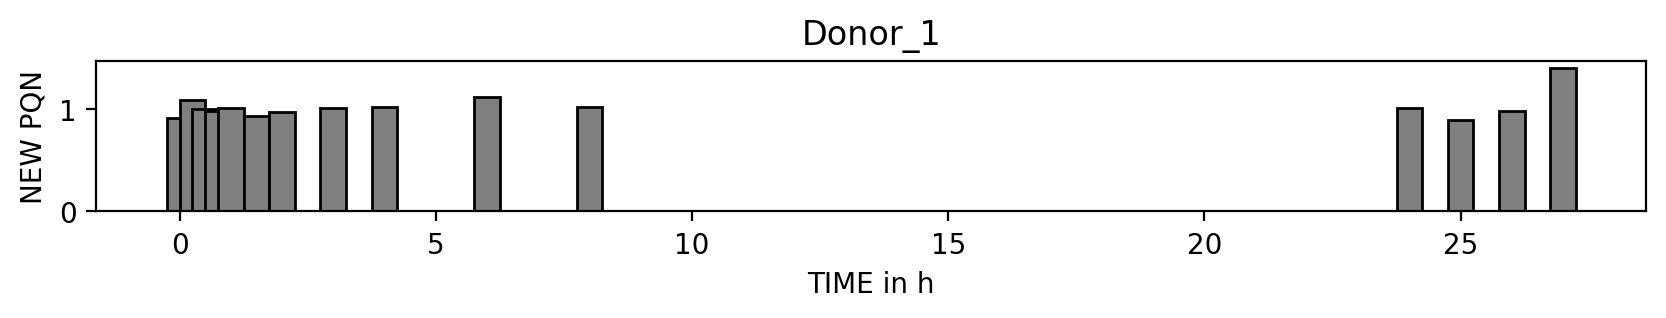

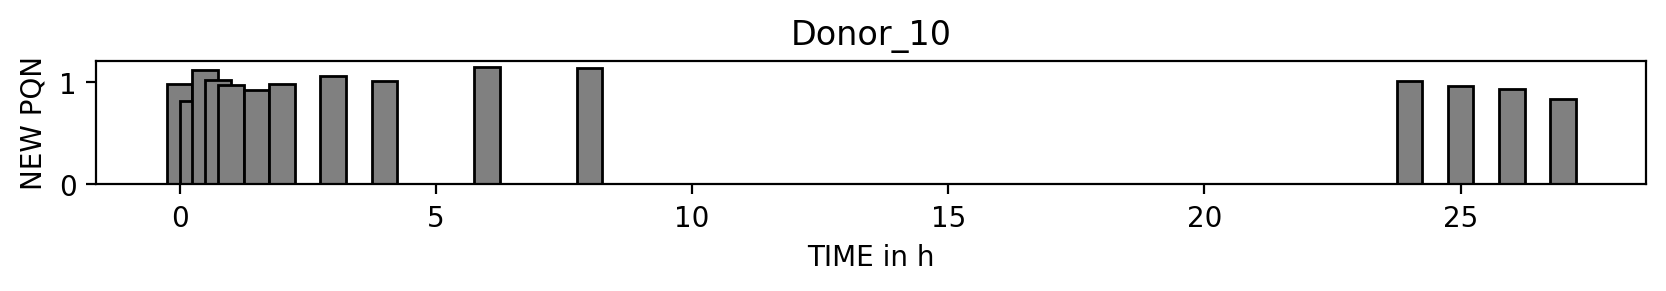

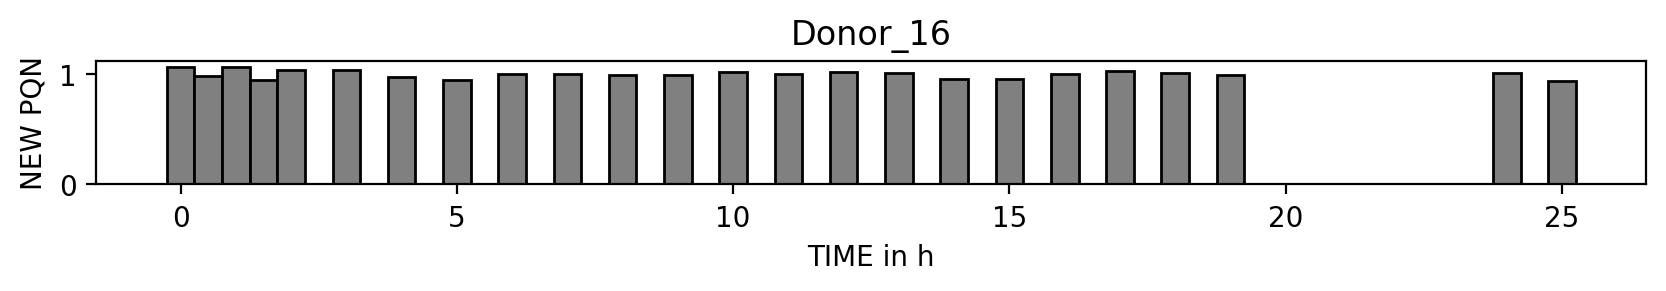

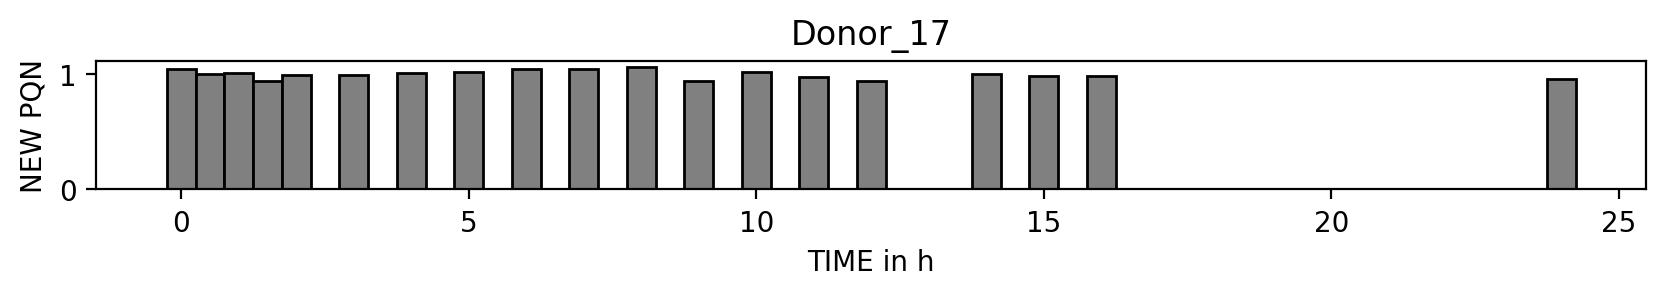

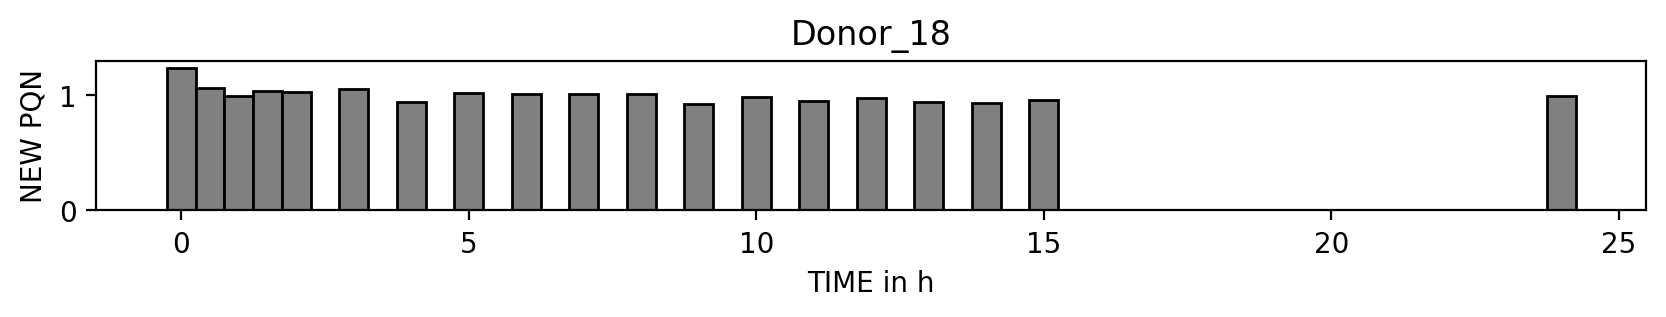

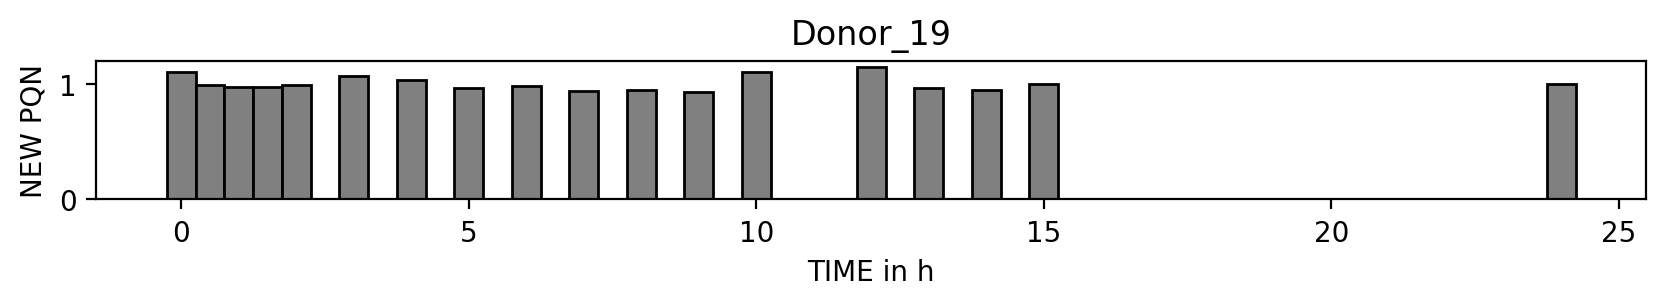

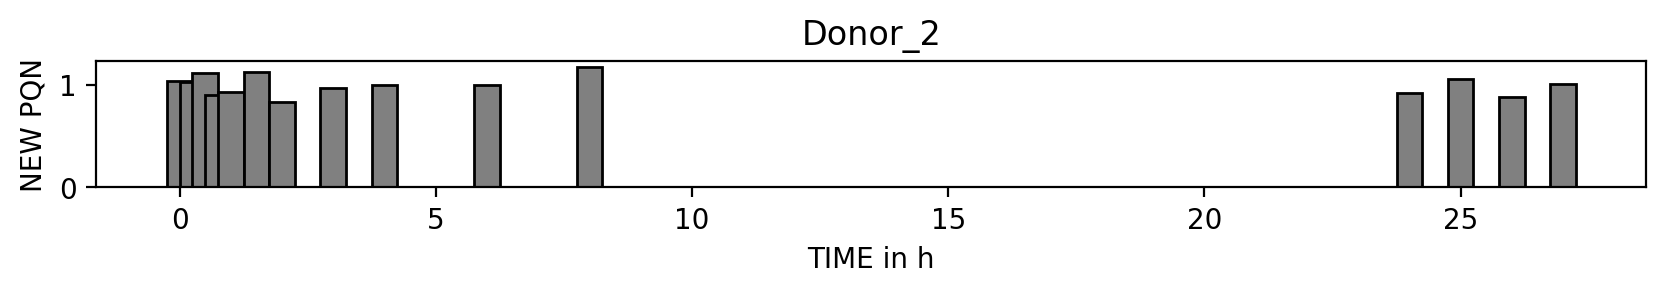

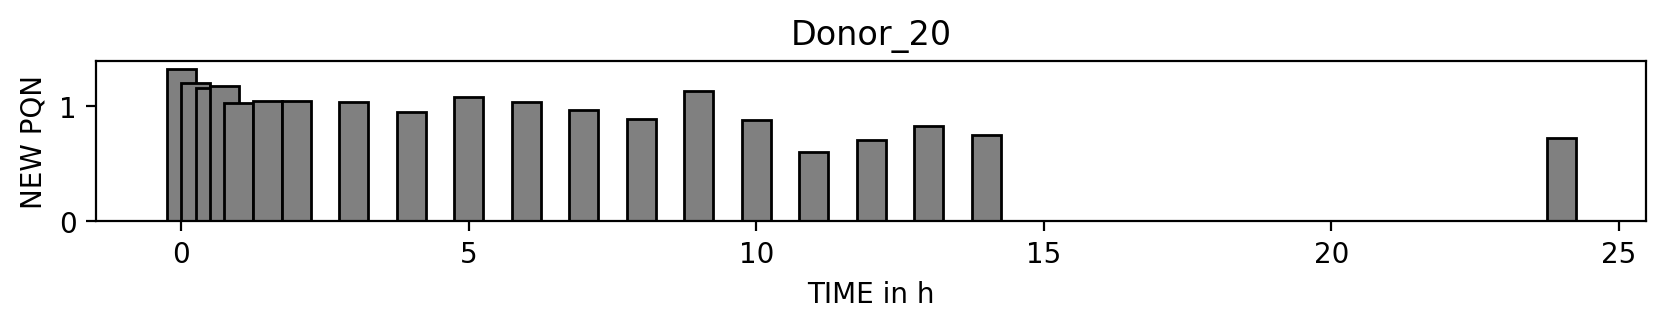

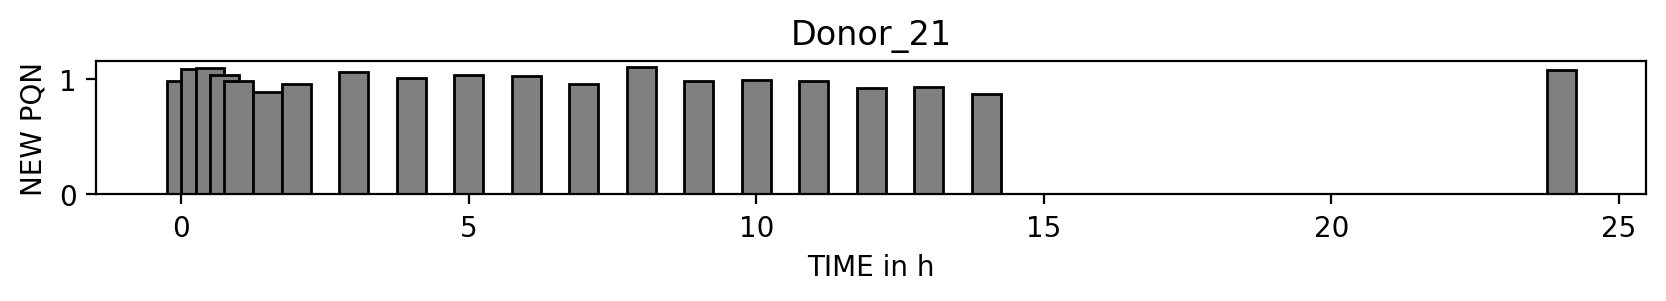

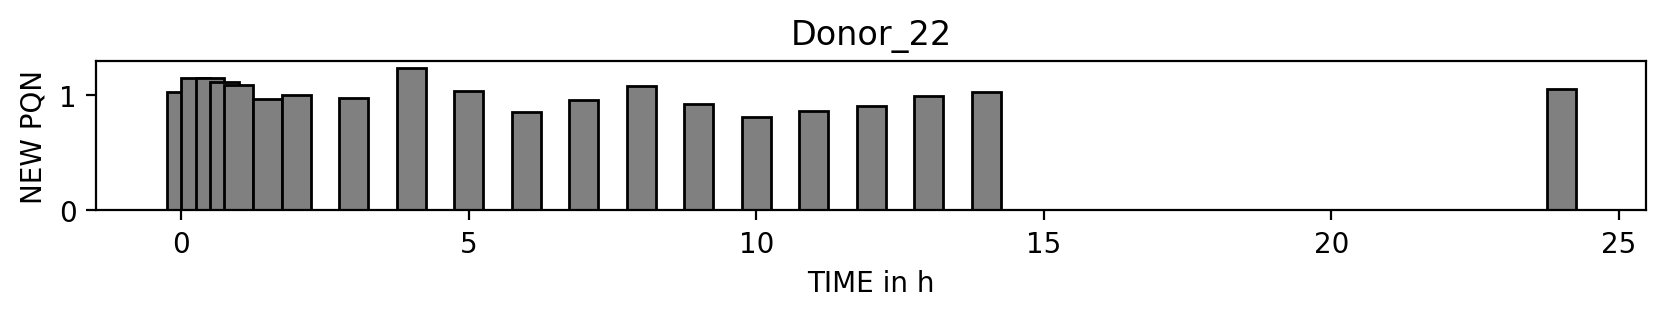

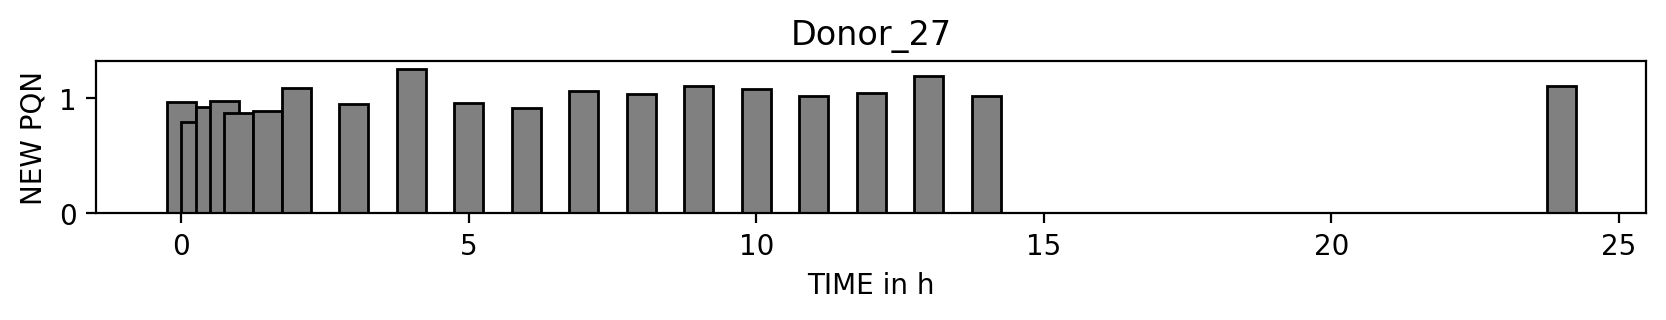

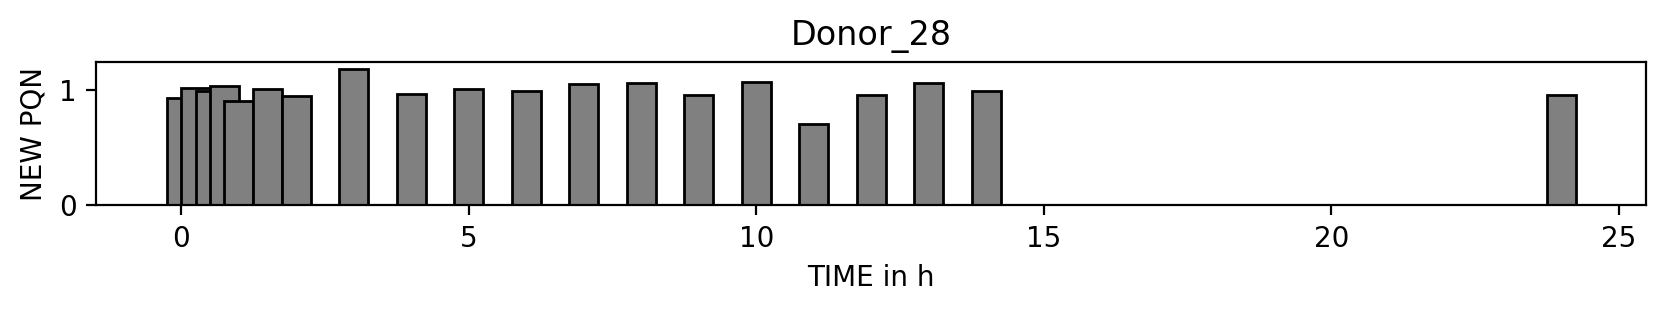

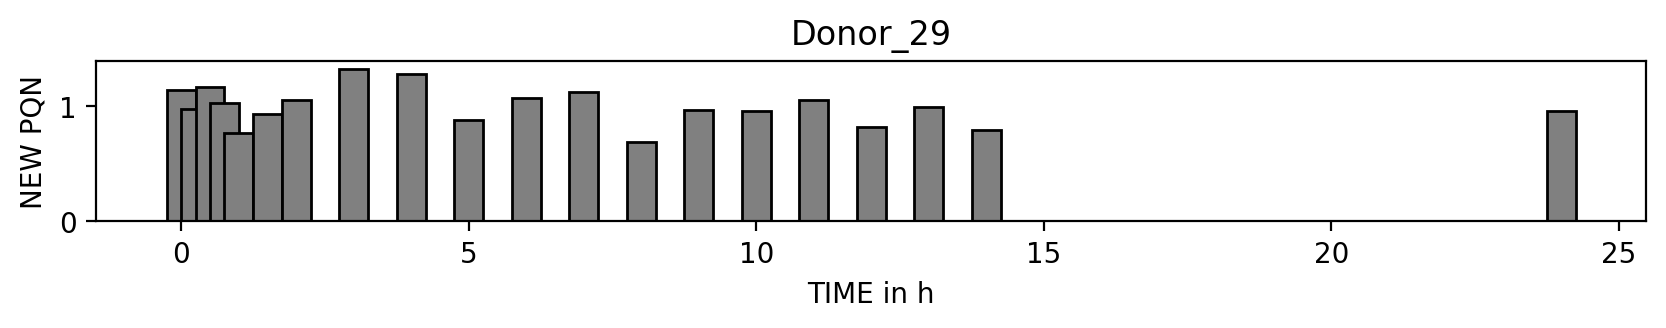

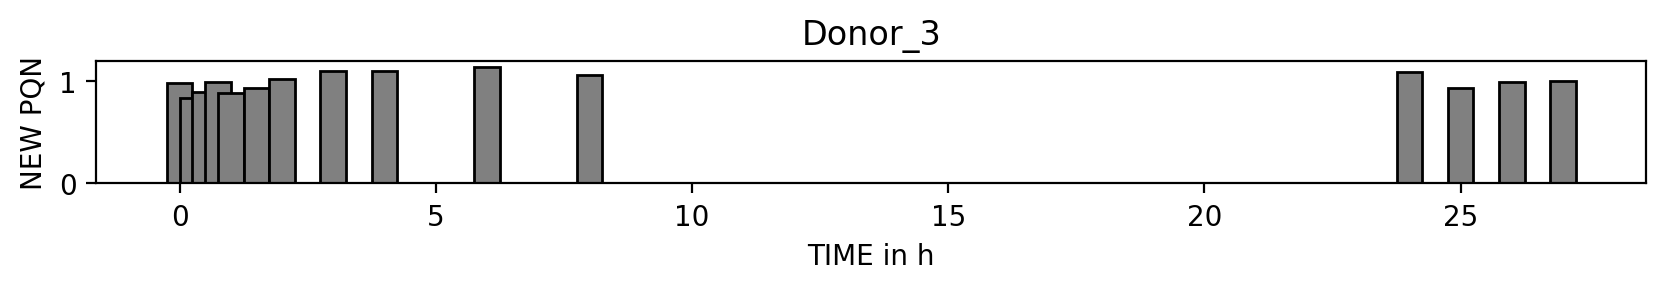

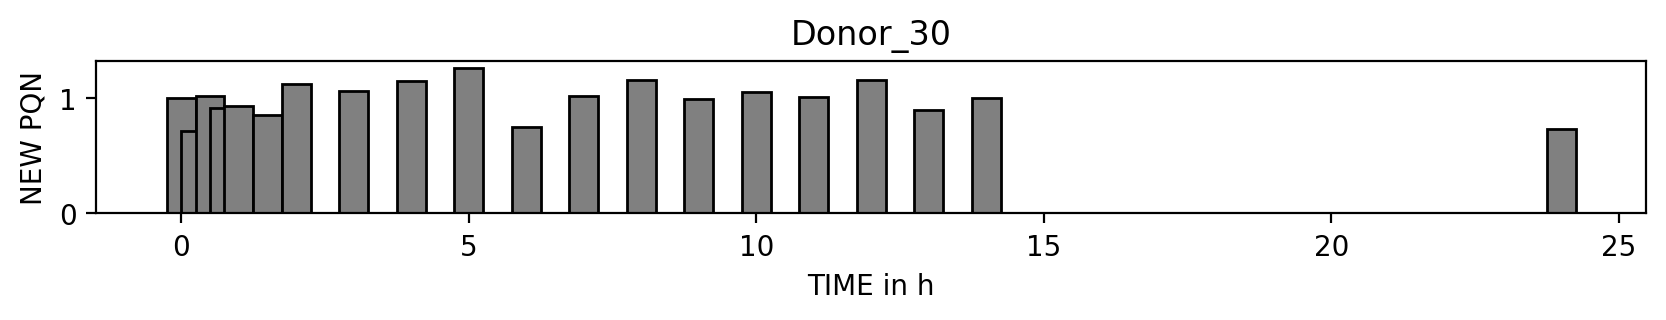

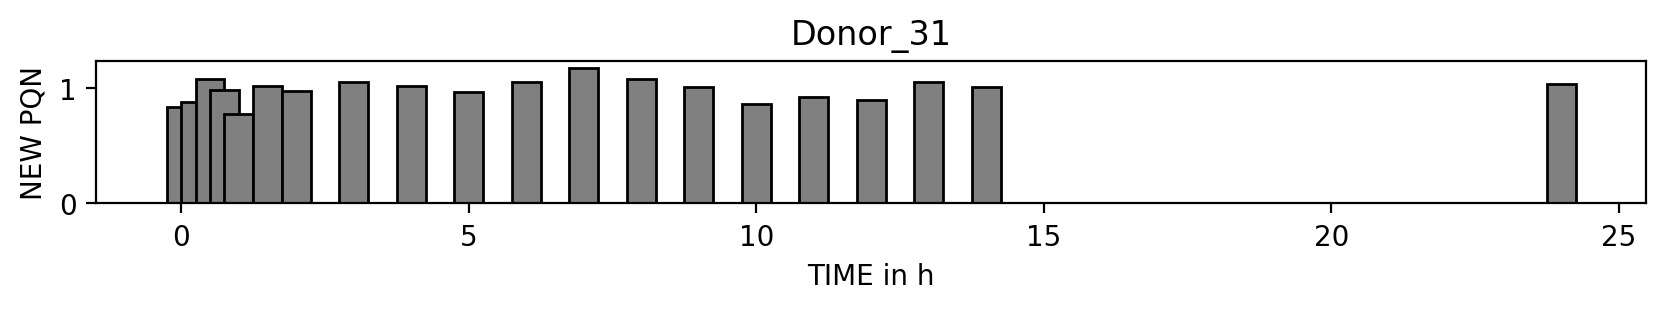

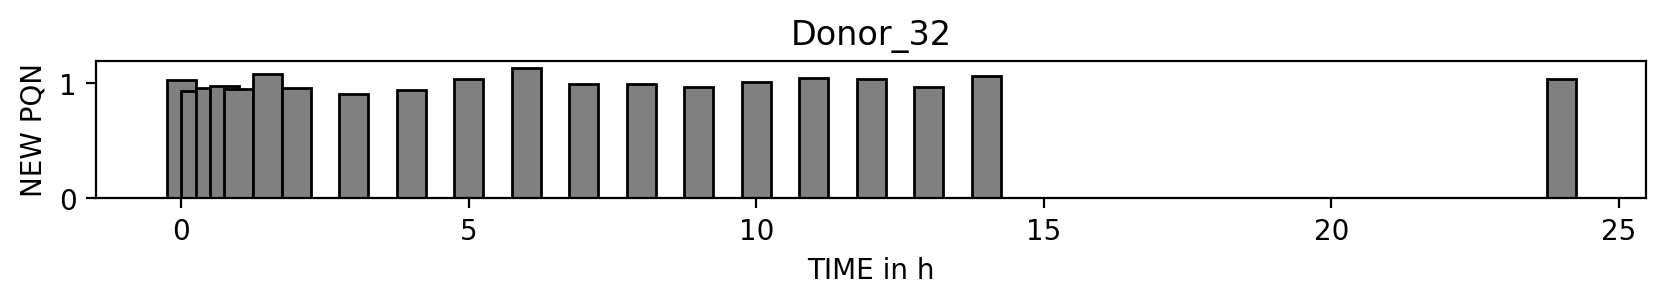

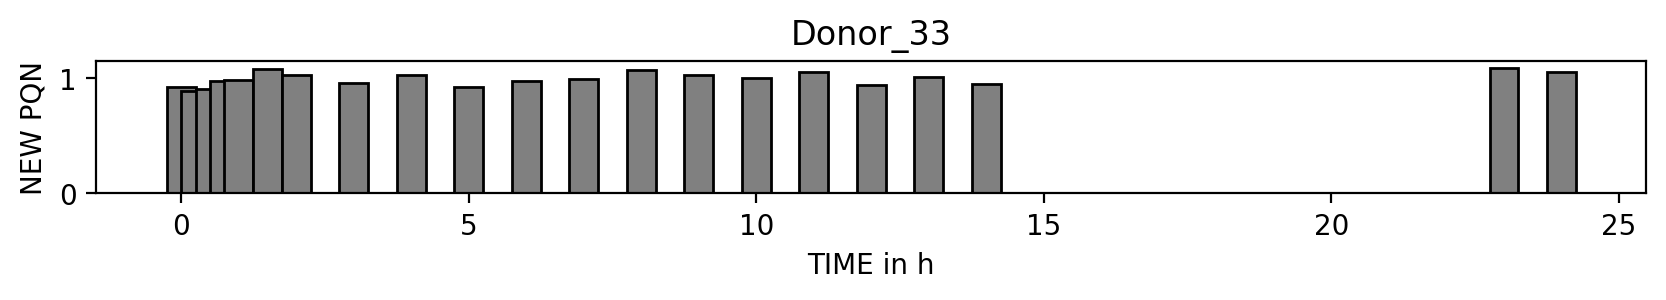

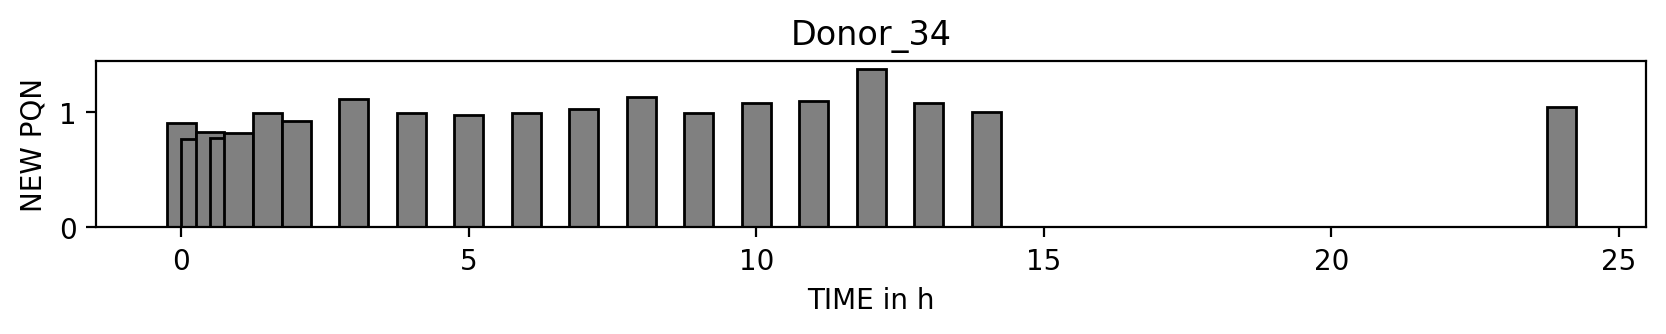

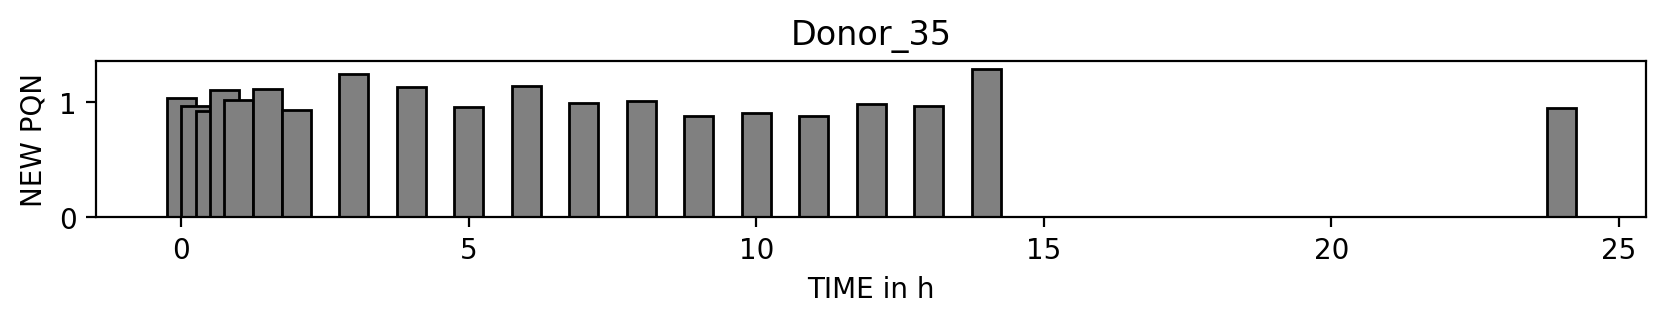

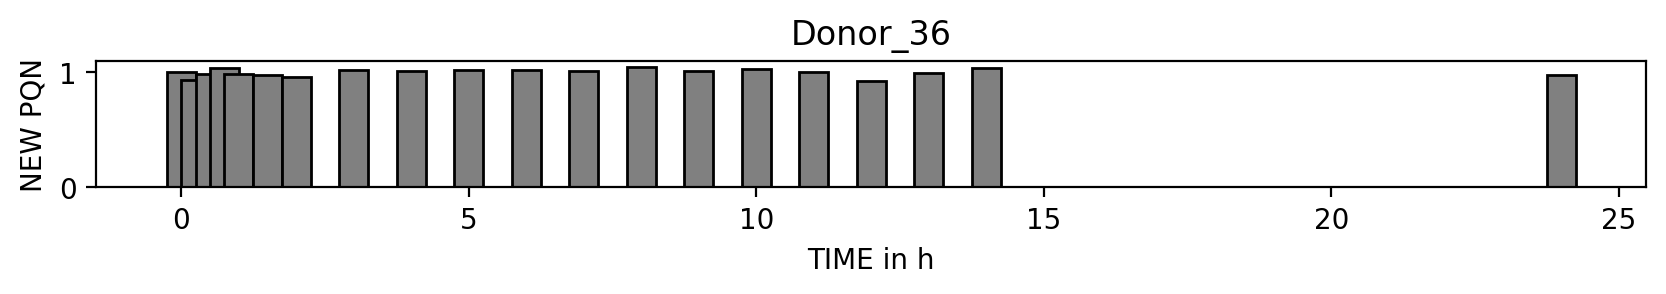

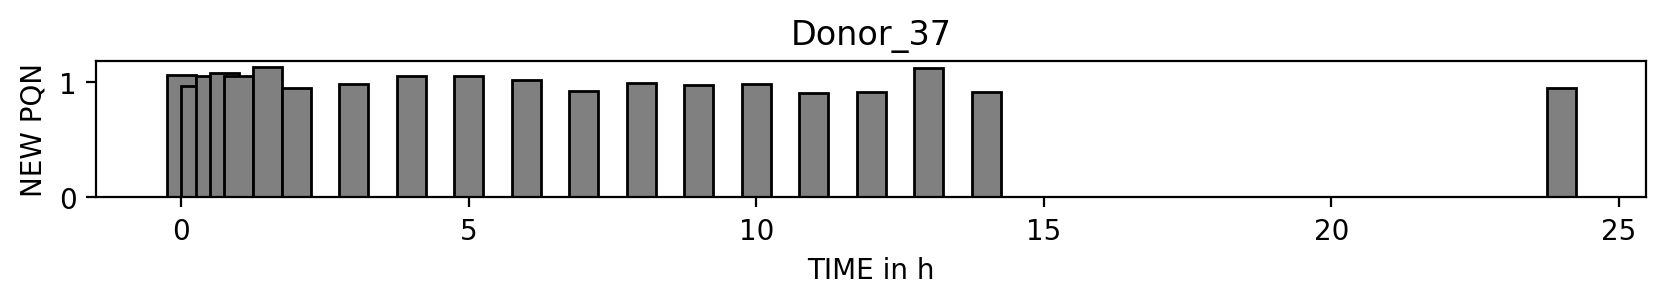

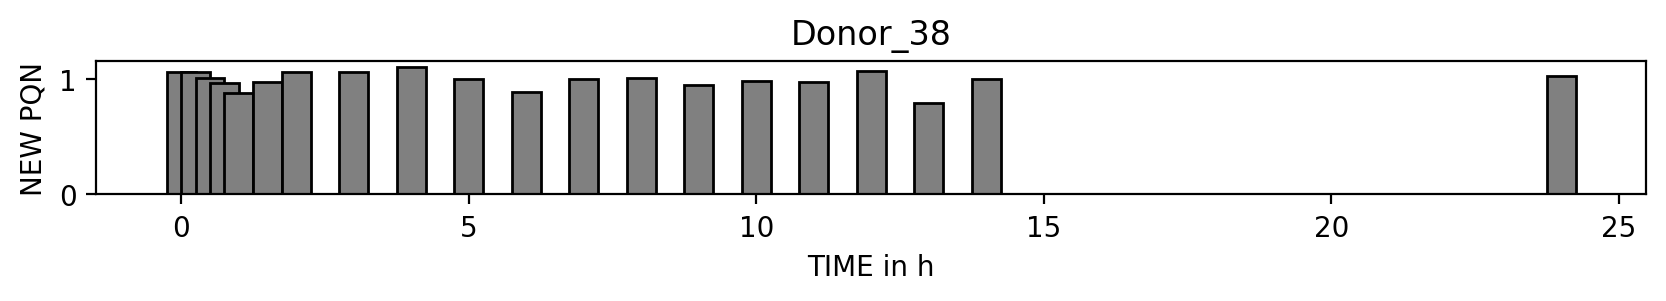

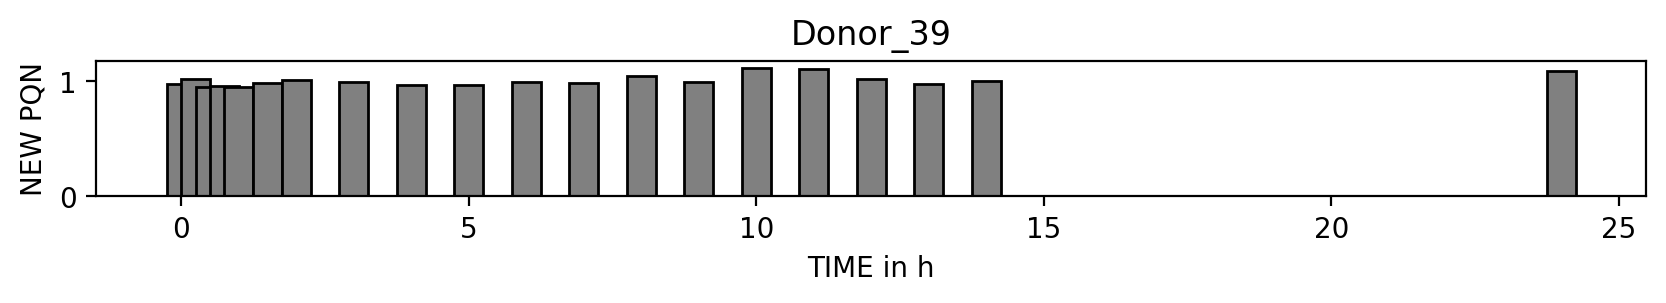

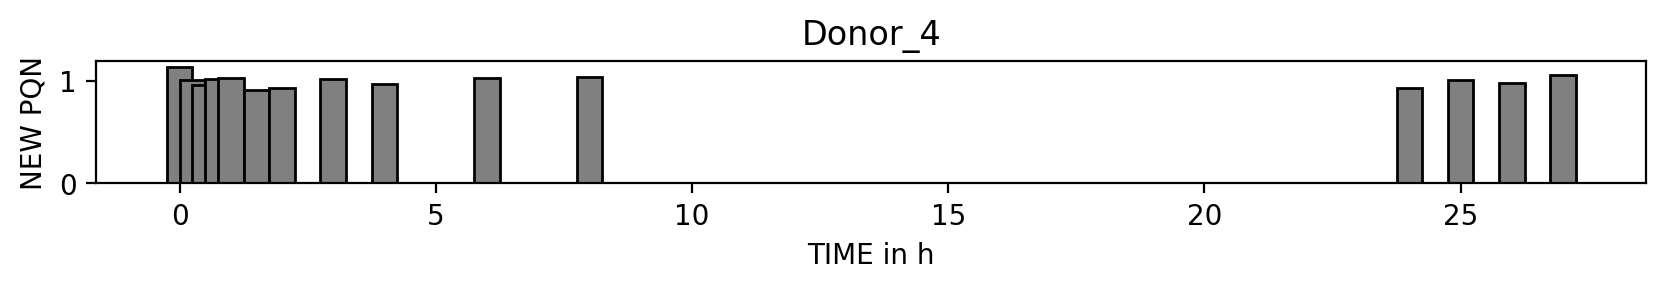

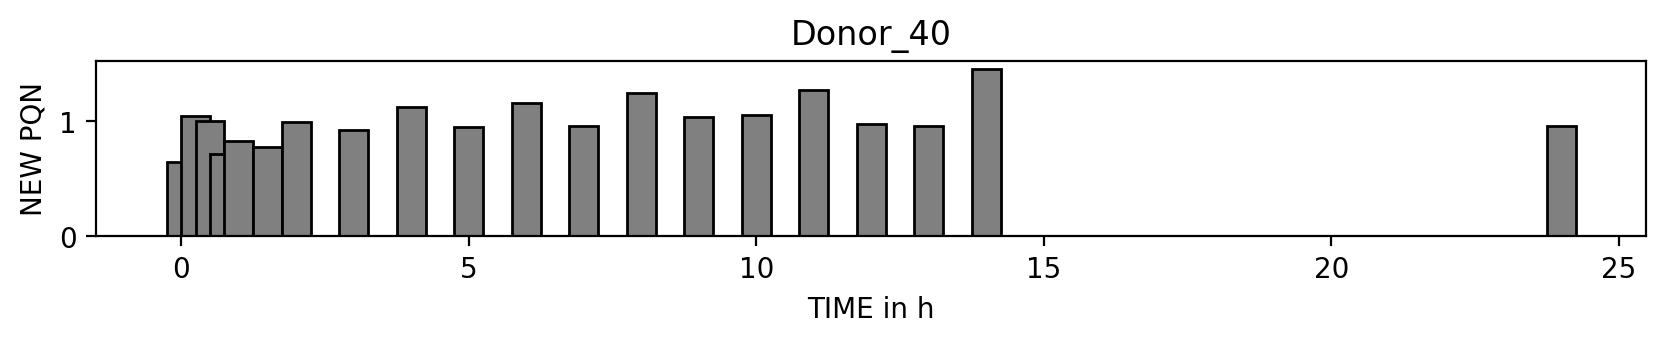

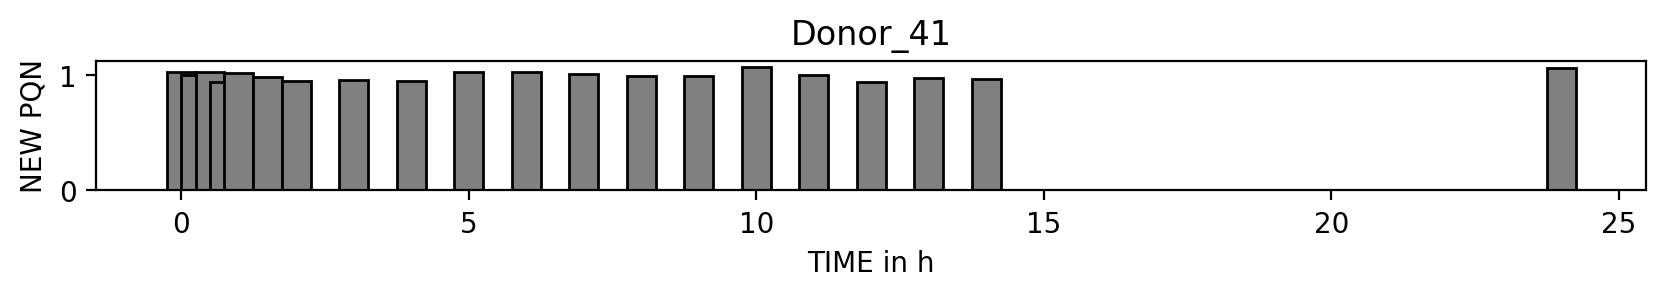

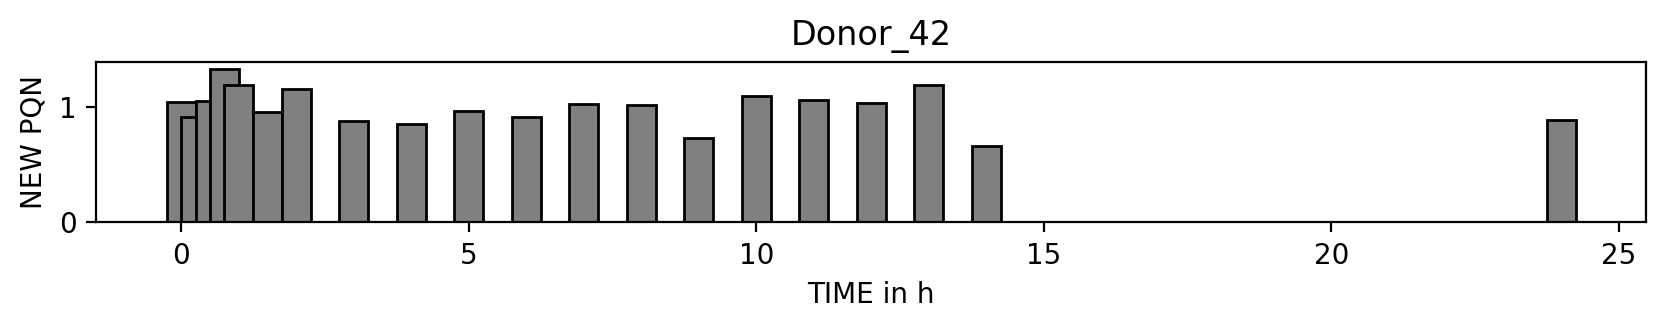

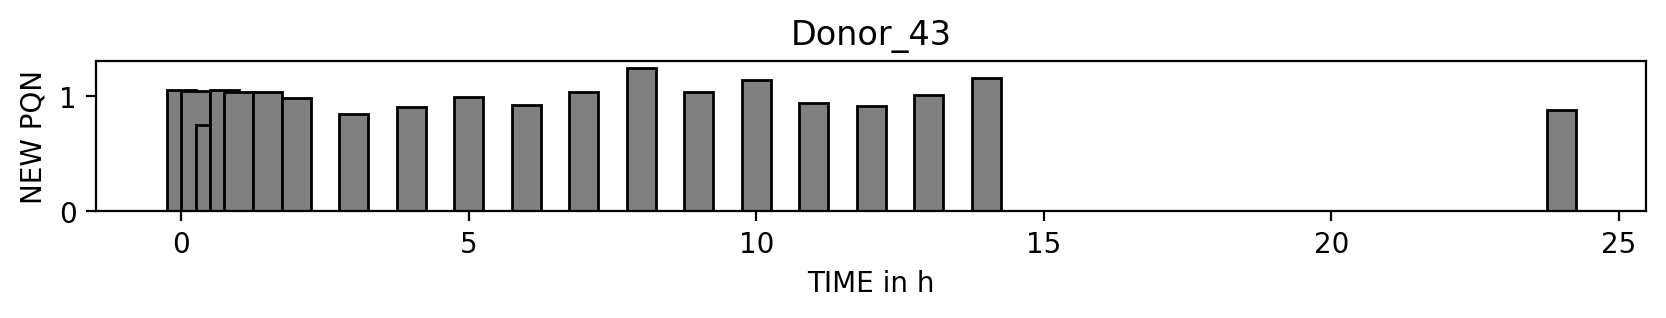

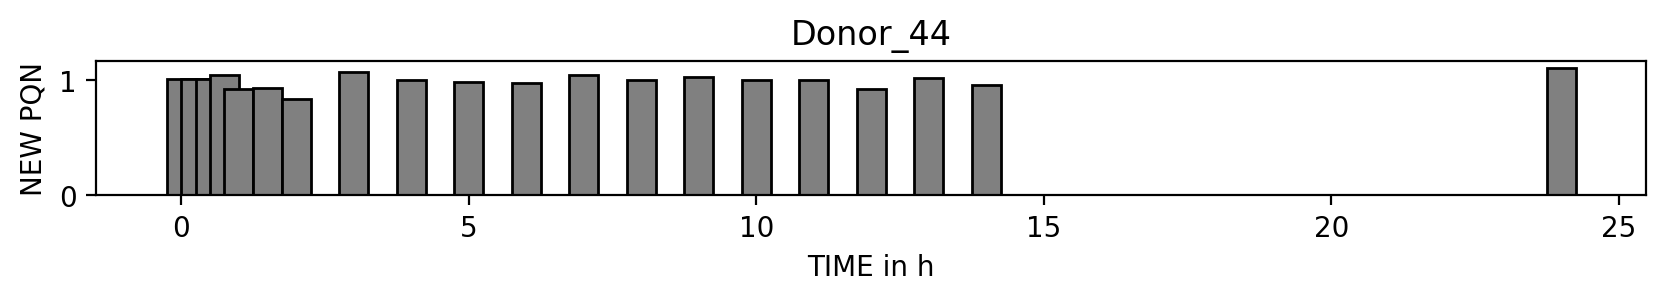

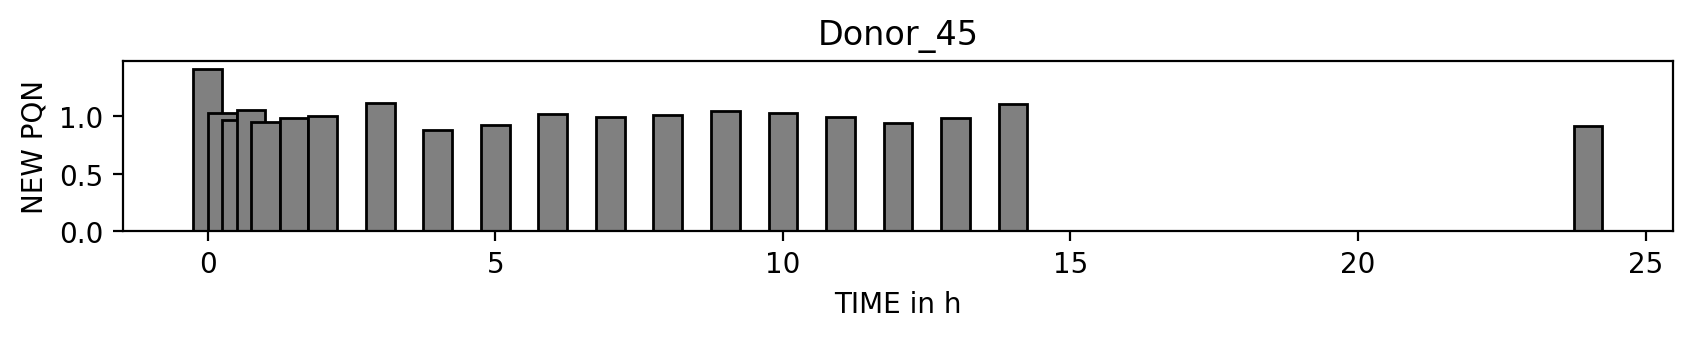

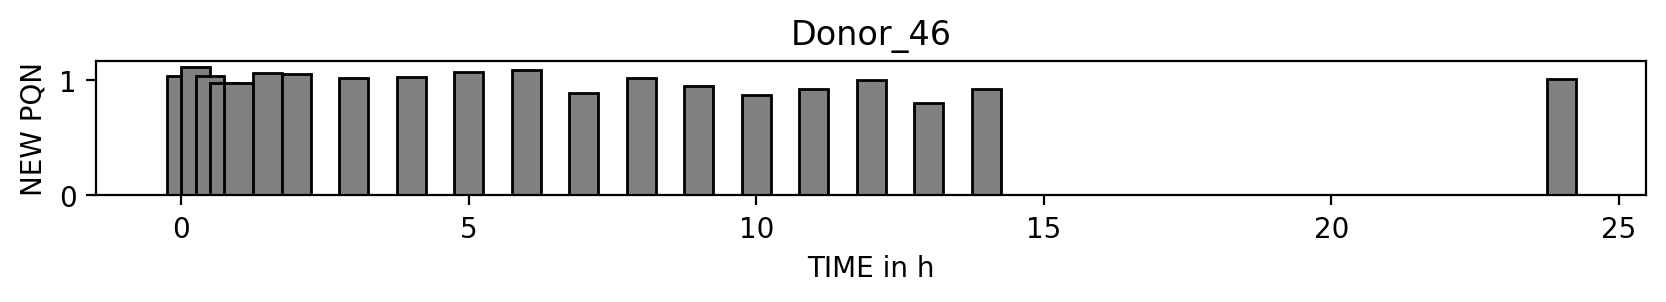

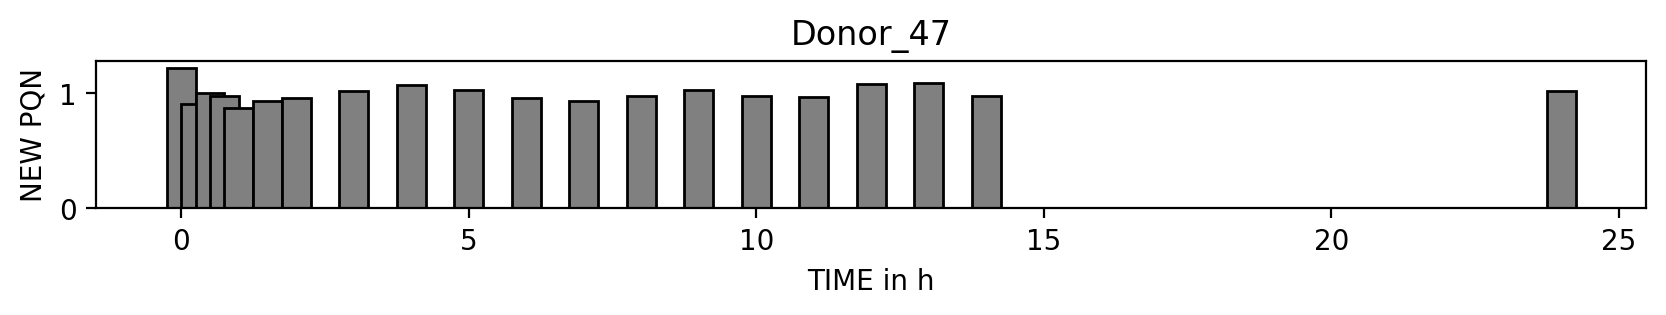

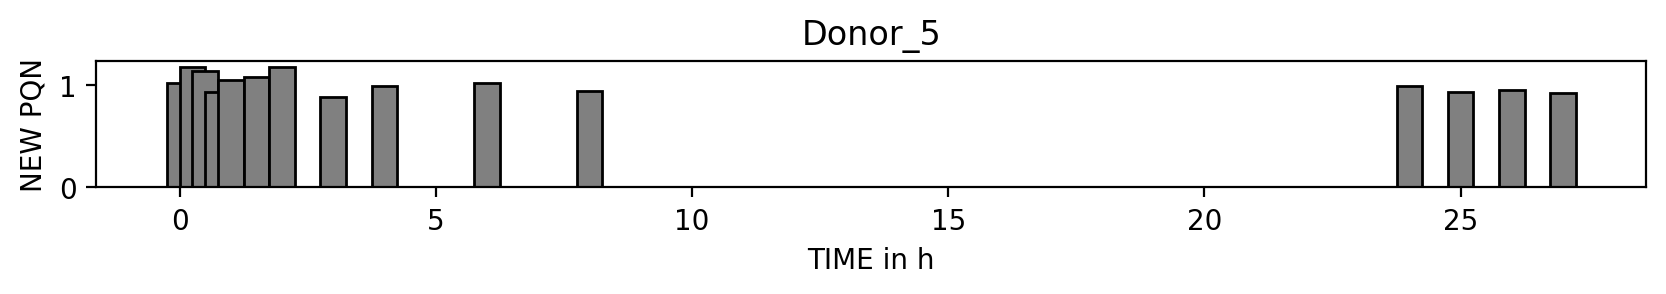

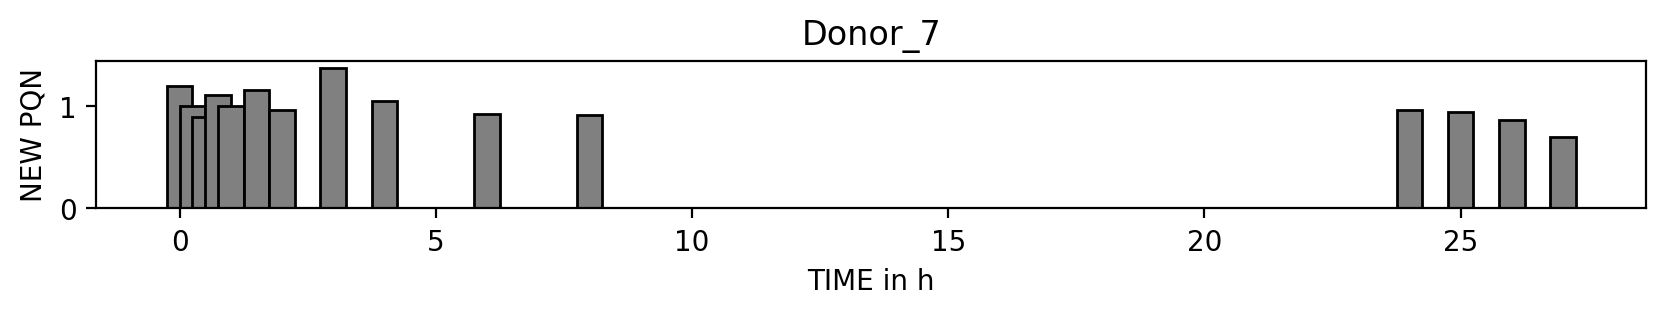

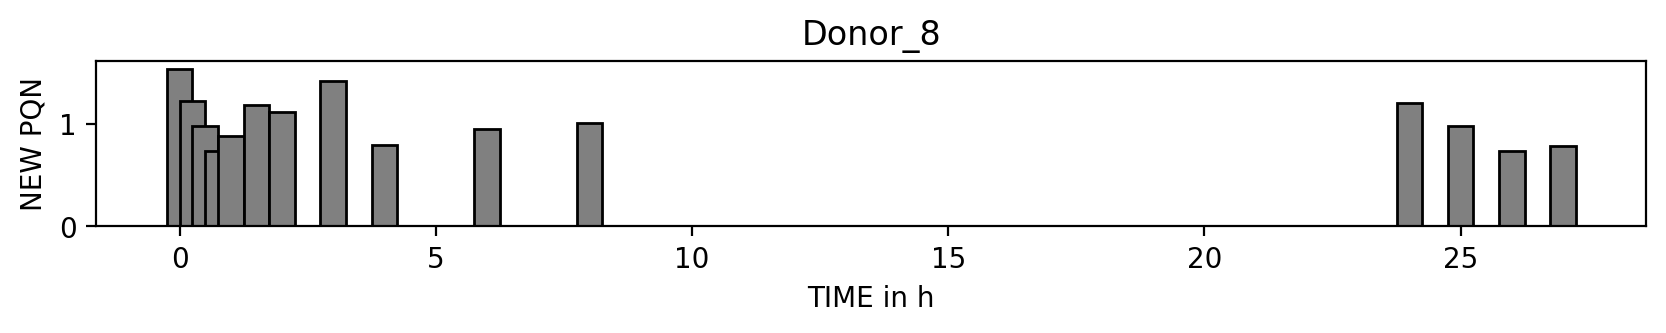

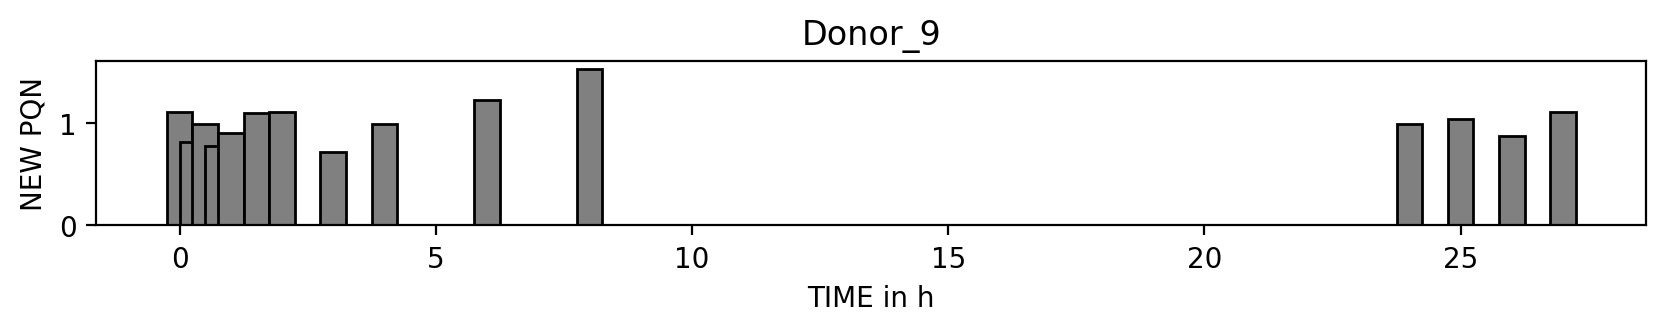

In [11]:
import scipy.stats as ss

def fast_avg(array):
    return np.mean(array.reshape(2,-1,order='F'),axis=0)

def fast_avg_matrix(array):
    return np.mean(array.reshape(2,-1,array.shape[1],order='F'),axis=0)

old_donors = ['Donor_1', 'Donor_10', 'Donor_16', 'Donor_17', 'Donor_18', 'Donor_19', 'Donor_2', 'Donor_20', 'Donor_21', 'Donor_22', 'Donor_27', 'Donor_28', 'Donor_29', 'Donor_3', 'Donor_30', 'Donor_31', 'Donor_32', 'Donor_33', 'Donor_34', 'Donor_35', 'Donor_36', 'Donor_37', 'Donor_38', 'Donor_39', 'Donor_4', 'Donor_40', 'Donor_41', 'Donor_42', 'Donor_43', 'Donor_44', 'Donor_45', 'Donor_46', 'Donor_47', 'Donor_5', 'Donor_7', 'Donor_8', 'Donor_9']

for donor in old_donors:
    tmpfull = full[full['donor']==donor]
    if donor == 'Donor_19':
        # there was something weird in the QC of the masured data, so timepoint 11 should be removed!
        tmpfull = tmpfull[tmpfull['time'] != 11]
    tmpnorm = tmpfull.loc[:,EXCL[donor][0]]/tmpfull.loc[:,'feature_3958'].values[:,None]
    new_pqn = fast_avg(calculate_pqn(tmpnorm.values.T))
    
    # write out data
    pqn_df = pd.DataFrame(index=range(len(fast_avg(tmpfull['time'].values))),columns=['PQN'])
    pqn_df.loc[:,'PQN'] = new_pqn
    pqn_df.insert(0,'time',fast_avg(tmpfull['time'].values))
    pqn_df.to_csv(f'pqn/{donor}.csv')
    norm_df = tmpnorm.copy()
    norm_df.insert(0,'time',tmpfull['time'].values)
    norm_df.index = range(norm_df.shape[0])
#     norm_df.to_csv(f'data/{donor}.csv')
    
    # begin figure
    plt.figure(dpi=200,figsize=(10,3))
    plt.subplot(111,aspect=2)
    plt.title(donor)
    plt.bar(fast_avg(tmpfull['time'].values),new_pqn,color='grey',edgecolor='k',width=.5)
    plt.ylabel('NEW PQN')
    plt.xlabel('TIME in h')
    plt.show()
#     break

# Combine Data with 20 time points and write them out

In [12]:
old_donors = ['Donor_1', 'Donor_10', 'Donor_16', 'Donor_17', 'Donor_18', 'Donor_19', 'Donor_2', 'Donor_20', 'Donor_21', 'Donor_22', 'Donor_27', 'Donor_28', 'Donor_29', 'Donor_3', 'Donor_30', 'Donor_31', 'Donor_32', 'Donor_33', 'Donor_34', 'Donor_35', 'Donor_36', 'Donor_37', 'Donor_38', 'Donor_39', 'Donor_4', 'Donor_40', 'Donor_41', 'Donor_42', 'Donor_43', 'Donor_44', 'Donor_45', 'Donor_46', 'Donor_47', 'Donor_5', 'Donor_7', 'Donor_8', 'Donor_9']
donors = old_donors
# I just want old donors that have 20 time points!
comb_list = []
norm_list = []
for donor in old_donors:
    if not '23' in donor:
        tmp_data = pd.read_csv(f'data/{donor}.csv',index_col=0)
        pqn_data = pd.read_csv(f'pqn/{donor}.csv',index_col=0)
        if len(tmp_data.loc[:,'time'].unique()) == 20:
#             print(donor)
            tmp_data.columns = ['time']+['{}_{}'.format(donor,i) for i in tmp_data.iloc[:,1:].columns]
            tmp_norm = pd.DataFrame(index=range(20),dtype=float,columns=tmp_data.columns[1:])
            tmp_norm.loc[:,:] = fast_avg_matrix(tmp_data.iloc[:,1:].values)/pqn_data['PQN'].values[:,None]
            comb_list.append(tmp_data.iloc[:,1:])
            norm_list.append(tmp_norm)
#             break
combined = pd.concat(comb_list,axis=1)
print(combined.shape)
# combined.to_csv('data/combined_20_timepoints.csv')
normalized = pd.concat(norm_list,axis=1)
print(normalized.shape)
# normalized.to_csv('data/normalized_20_timepoints.csv')
print('done')

(40, 6770)
(20, 6770)
done
